In [ ]:
!pip install voxelmorph

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 92kB 4.0MB/s 


In [ ]:
import voxelmorph as vxm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data and Affine transform

In [ ]:
# load MNIST and extract a small image
pad_amt = 10
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
im = x_train[0, ...].astype('float')/255
im = np.pad(im, ((pad_amt, pad_amt), (pad_amt, pad_amt)))

# random affine to apply (could be much smarter about this)
aff = np.eye(3)
aff[:2, :2] += np.random.randn(2, 2) * 0.1
aff[:2, 2] = np.random.uniform(-10, 10, (2, ))
aff_inv = np.linalg.inv(aff)

# take out some random annotation locations to warp later
margin = 10
nb_annotations = 5
annotations = [np.random.uniform(margin, f - margin, nb_annotations) for f in im.shape] 
annotations = np.stack(annotations, 1)

11493376/11490434 [==============================] - 0s 0us/step


# Warp Data

In [ ]:
# transform to keras shape
im_keras = im[np.newaxis, ..., np.newaxis]
aff_keras = aff[np.newaxis, :2, :]
annotations_keras = annotations[np.newaxis, ...]

# warp image
im_warped = vxm.layers.SpatialTransformer(add_identity=False)([im_keras, aff_keras])
im_warped = im_warped[0, ..., 0]

# get dense field of inverse affine
field_inv = vxm.utils.affine_to_shift(aff_inv, im.shape, shift_center=True)[np.newaxis, ...]

# warp annotations
data = [tf.convert_to_tensor(f, dtype=tf.float32) for f in [annotations_keras, field_inv]]
annotations_warped = vxm.utils.point_spatial_transformer(data)[0, ...].numpy()

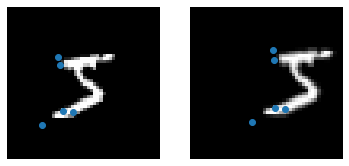

In [ ]:
plt.figure()

# note that x and y need to be flipped due to xy indexing in matplotlib
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray')
plt.plot(*[annotations[:, f] for f in [1, 0]], 'o')  
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_warped, cmap='gray')
plt.plot(*[annotations_warped[:, f] for f in [1, 0]], 'o')
plt.axis('off');